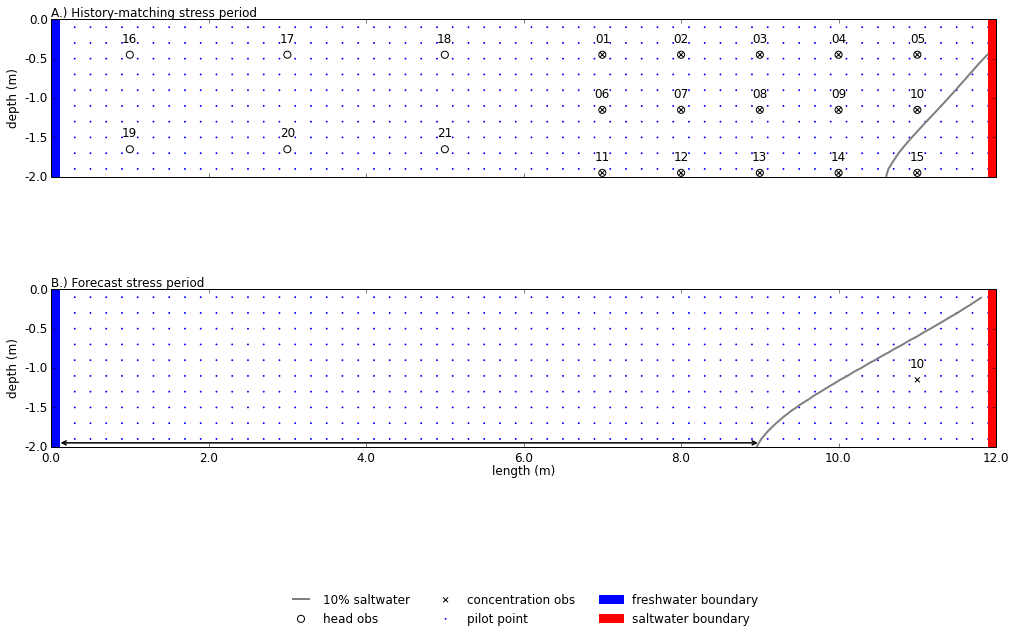

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas
import matplotlib.pyplot as plt
import plot_domain
plot_domain.henry_domain()
plt.show()

##Model background
Here is an example based on the Henry saltwater intrusion problem.  The synthetic model is a 2-dimensional SEAWAT model (X-Z domain) with 1 row, 120 columns and 20 layers.  The left boundary is a specified flux of freshwater, the right boundary is a specified head and concentration saltwater boundary.  The model has two stress periods: an initial steady state (calibration) period, then a transient period with less flux (forecast).  

The inverse problem has 603 parameters: 600 hydraulic conductivity pilot points, 1 global hydraulic conductivity, 1 specified flux multiplier for history matching and 1 specified flux multiplier for forecast conditions.  The inverse problem has 36 obseravtions (21 heads and 15 concentrations) measured at the end of the steady-state calibration period.  The forecasts of interest of the distance from the left model edge to the 10% seawater concentration in the basal model layer and the concentration at location 10.  Both of there forecasts are "measured" at the end of the forecast stress period.  The forecasts are both in the Jacobian matrix as zero-weight observations named `pd_ten` and `C_obs10_2`.I previously calculated the jacobian matrix, which is in the `henry/` folder, along with the PEST control file.



##Using `pyemu`

In [2]:
import pyemu

First create a linear_analysis object.  We will use `schur`  derived type, which replicates the behavior of the `PREDUNC` suite of PEST.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.

In [3]:
forecasts = ["pd_ten","c_obs10_2"]
la = pyemu.schur(jco=os.path.join("henry", "pest.jcb"), forecasts=forecasts)


The screen output can be redirected to a log file by passing a file name to the `verbose` keyword argument.  Or screen output can be stopped by passing `False` to the `verbose` argument

In [4]:
la = pyemu.schur(jco=os.path.join("henry", "pest.jcb"), forecasts=forecasts,verbose=False)
#obs_names = la.pst.obs_names
#[obs_names.remove(name) for name in ["pd_one","pd_ten","pd_half"]]
#la = la.get(par_names=la.pst.par_names,obs_names=obs_names)

We can inspect the parcov and obscov attributes by saving them to files.  We can save them PEST-compatible ASCII or binary matrices (`.to_ascii()` or `.to_binary()`), PEST-compatible uncertainty files (`.to_uncfile()`), or simply as numpy ASCII arrays (`numpy.savetxt()`).  In fact, all matrix and covariance objects (including the forecasts) have these methods.  


In [5]:
la.parcov.to_uncfile(os.path.join("henry", "parcov.unc"), covmat_file=os.path.join("henry","parcov.mat"))

When saving an uncertainty file, if the covariance object is diagonal (`self.isdiagonal == True`), then you can force the uncertainty file to use standard deviation blocks instead of covariance matrix blocks by explicitly passing `covmat_file` as `None`:

In [6]:
la.obscov.to_uncfile(os.path.join("henry", "obscov.unc"), covmat_file=None)

##Posterior parameter uncertainty analysis
Let's calculate and save the posterior parameter covariance matrix:

In [7]:
la.posterior_parameter.to_ascii(os.path.join("henry", "posterior.mat"))

You can open this file in a text editor to examine.  The diagonal of this matrix is the posterior variance of each parameter. Since we already calculated the posterior parameter covariance matrix, additional calls to the `posterior_parameter` decorated method only require access:


In [8]:
la.posterior_parameter.to_dataframe().sort().sort(axis=1).iloc[0:3,0:3] #look so nice in the notebook

,global_k,kr01c01,kr01c02
global_k,0.001619,-0.000003,-0.000004
kr01c01,-0.000003,0.249907,-0.000234
kr01c02,-0.000004,-0.000234,0.249402


We can see the posterior variance of each parameter along the diagonal of this matrix. Now, let's make a simple plot of prior vs posterior uncertainty for the 600 pilot point parameters

In [9]:
par_sum = la.get_parameter_summary().sort()
par_sum.iloc[0:10,:]

,percent_reduction,post_var,prior_var
global_k,47.366438,0.001619,0.003076
kr01c01,0.037235,0.249907,0.250000
kr01c02,0.239296,0.249402,0.250000
kr01c03,0.478126,0.248805,0.250000
kr01c04,0.561536,0.248596,0.250000
kr01c05,0.224638,0.249438,0.250000
kr01c06,0.634948,0.248413,0.250000
kr01c07,1.261772,0.246846,0.250000
kr01c08,1.229091,0.246927,0.250000
kr01c09,1.161905,0.247095,0.250000


We can see that the at most, the uncertainty of any one of the 600 hydraulic conductivity parameters is only reduced by 5% and the uncertainty of many parameters has not been reduced at all, meaning these parameters are not informed by the observations.  

##Prior forecast uncertainty
Now let's examine the prior variance of the forecasts:

In [10]:
prior = la.prior_forecast
print(prior) # dict keyed on forecast name


{'c_obs10_2': 1.0233538567248415, 'pd_ten': 4.6659150608904687}


Sometimes, it is more intuitive to think in terms of standard deviation, which in this case has units of ```meters``` and can be thought of as the "+/-" around the model-predicted distance from the left edge of the domain to the three saltwater concentration contours

In [11]:
for pname,var in la.prior_forecast.items():
    print(pname,np.sqrt(var))

c_obs10_2 1.01160953768
pd_ten 2.16007292953


##Posterior forecast uncertainty
Now, let's calculate the posterior uncertainty (variance) of each forecast:

In [12]:
post = la.posterior_forecast
for pname,var in post.items():
    print(pname,np.sqrt(var))

c_obs10_2 0.567518724659
pd_ten 1.38413050211


That's it - we have completed linear-based uncertainty analysis for a model with 603 parameters and we completed it before actual inversion so we can estimate the worth of continuing and actually completing the expense inversion process!  We can see that the data we have provide atleast some conditioning to each of these forecasts, indicating that the history-matching process is valuable:

In [13]:
la.get_forecast_summary()

,percent_reduction,post_var,prior_var
c_obs10_2,68.52726,0.322078,1.023354
pd_ten,58.94016,1.915817,4.665915


It is interesting that the uncertainty of the forecasts is reduced substantially even though the uncertainty for any one parameter is only slightly reduced.  This is because the right combinations of forecast-sensitive parameters are being informed by the observations.

##Data worth
Now, let's try to identify which observations are most important to reducing the posterior uncertainty (e.g.the forecast worth of every observation).  We simply recalculate Schur's complement without some observations and see how the posterior forecast uncertainty increases


```importance_of_obesrvation_groups()``` is a thin wrapper that calls the underlying ```importance_of_observations()``` method using the observation groups in the pest control file and stacks the results into a ```pandas DataFrame```.  

lets see if the heads or the concentrations are more important:

In [14]:
df = la.get_importance_dataframe_groups()
df

,c_obs10_2,pd_ten
base,0.322078,1.915817
head,0.404700,2.049045
conc,0.329814,1.951361


```base``` row are the results of Schur's complement calculation using all observations.  The increase in posterior forecast uncertainty for the ```head``` and ```conc``` cases show how much forecast uncertainty increases when the head and concentrations observations are not used in history matching

So, it looks like the heads and concentrations are both important for reducing the posterior uncertainty of the forecasts. 

##parameter contribution to uncertainty
Lets look at which parameters are contributing most to forecast uncertainty.  for demostration purposes, lets group the hydraulic conductivity parameters by row.

In [15]:
par_groups = {}
for pname in la.pst.par_names:
    if pname.startswith('k'):
        row = "k_row_"+pname[2:4]
        if row not in par_groups.keys():
            par_groups[row] = []
        par_groups[row].append(pname)

par_groups["global_k"] = "global_k"
par_groups["histmatch_mult"] = "mult1"
par_groups["forecast_mult"] = "mult2"
df = la.get_contribution_dataframe(par_groups)
df

c_obs10_2                             pd_ten            \
               percent_reduce      post     prior percent_reduce      post   
base                68.527260  0.322078  1.023354      58.940160  1.915817   
forecast_mult       81.871195  0.155284  0.856561      69.605044  1.200906   
histmatch_mult      73.559461  0.266151  1.006600      65.483163  1.547308   
k_row_10            69.430392  0.304540  0.996218      69.390068  1.146088   
global_k            64.248012  0.282183  0.789280      44.339568  1.609255   
k_row_09            69.205740  0.310422  1.008050      59.161308  1.874214   
k_row_08            69.919002  0.303464  1.008824      59.060569  1.899291   
k_row_01            62.746747  0.312887  0.839891      56.021874  1.909495   
k_row_03            66.074033  0.318947  0.940126      57.531430  1.914755   
k_row_02            64.505329  0.319494  0.900117      56.853135  1.913996   
k_row_05            68.111987  0.312639  0.980427      58.368625  1.912850   
k_row_04            67.285394  0.315075  0.963101      58.009410  1.914275   
k_row_07            68.669516  0.309507  0.987877      58.910502  1.904444   
k_row_06            68.654458  0.314450  1.003174      58.617939  1.911140   

                          
                   prior  
base            4.665915  
forecast_mult   3.951004  
histmatch_mult  4.482763  
k_row_10        3.744171  
global_k        2.891201  
k_row_09        4.589309  
k_row_08        4.639271  
k_row_01        4.341920  
k_row_03        4.508640  
k_row_02        4.436002  
k_row_05        4.594731  
k_row_04        4.558819  
k_row_07        4.634868  
k_row_06        4.618282

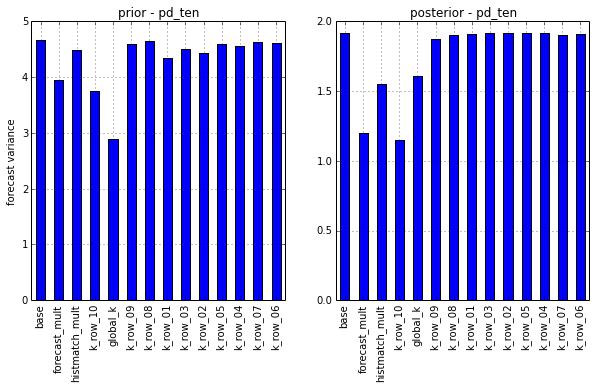

In [16]:
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
df_pr = df.loc[:,pandas.IndexSlice["pd_ten","prior"]]
df_pt = df.loc[:,pandas.IndexSlice["pd_ten","post"]]
df_pr.plot(kind="bar",figsize=(10,5),title="prior - pd_ten",
           ax=ax1,legend=False)
df_pt.plot(kind="bar",figsize=(10,5),title="posterior - pd_ten",
           ax=ax2,legend=False)
ax1.set_ylabel("forecast variance")
plt.show()

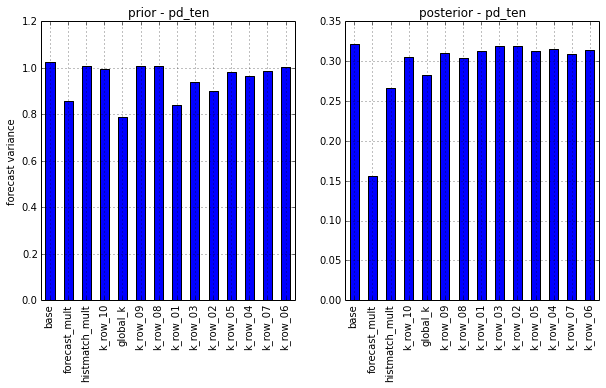

In [17]:
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
df_pr = df.loc[:,pandas.IndexSlice["c_obs10_2","prior"]]
df_pt = df.loc[:,pandas.IndexSlice["c_obs10_2","post"]]
df_pr.plot(kind="bar",figsize=(10,5),title="prior - pd_ten",
           ax=ax1,legend=False)
df_pt.plot(kind="bar",figsize=(10,5),title="posterior - pd_ten",
           ax=ax2,legend=False)
ax1.set_ylabel("forecast variance")
plt.show()

We see that the largest contributions to forecast uncertainty depends on the forecast. Forecast ```pd_ten``` is most sensitive to hydraulic conductivity parameters in row 10.  However, Forecast ```c_obs10_2``` is most sensitive to the ```forecast_mult``` parameter.